[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/exercises/Ex04-NN-Primer-part1.ipynb) 

# ADAMS Tutorial #4: Neural Networking (NN) Primer
The elaborates on concepts covered in the Foundations of NN and NN Training lectures. It splits into two parts, the outline of which is as follows:

## Phase 1 : setting up a NN ##

 1. use case
 2. from logit to neural network
 3. nn structure: weights and biases
 3. activation function
 4. softmax
 5. application


## Phase 2 : make it work ##
 1. loss function
 2. gradient
 3. weight update
 4. learning rate
 5. stochastic gradient descent and backpropagation
 6. application

# Phase 1: setting up a NN # 

## 1.1 use case: app rating analysis ##
NNs often solve classification problems with many classes. To illustrate their functioning in a context that is more related to later NLP examples, we will leave the space of credit scoring and introduce a new data set concerned with app ratings. The original data is available on [Kaggle](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps). There, you also find a data dictionary with some information on the variables. However, the variable names are rather self-explanatory. A cleaned version of the data is available in Moodle. The easiest way for you is to use the Moodle version but feel very free to play around with the version on Kaggle. You can find a Python script that starts from the original data and goes through a couple of pre-processing operations to produce the version we use below in our GitHub ([app_store_dpp.py](https://github.com/Humboldt-WI/adams/tree/master/exercises/app_store_dpp.py)).

In [1]:
import pandas as pd
app = pd.read_csv("../../data/AppleStore_prep.csv",index_col=False,sep='\t', encoding='utf-8')
app.head(5)

,track_name,size_bytes,price,rating_count_tot,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,currency_USD,cont_rating_12+,...,prime_genre_Photo & Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather,user_rating
0,PAC-MAN Premium,-0.273806,0.388126,0.110902,0.170753,0.651051,0.576471,0.083642,1,0,...,0,0,0,0,0,0,0,0,0,4.0
1,Evernote - stay organized,-0.112911,-0.295960,1.956477,-0.096808,0.651051,2.218083,0.083642,1,0,...,0,1,0,0,0,0,0,0,0,4.0
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",-0.274542,-0.295960,2.319827,-0.096808,0.651051,-0.307474,0.083642,1,0,...,0,0,0,0,0,0,0,0,1,4.0
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",-0.196620,-0.295960,3.292413,-0.096808,0.651051,0.450193,0.083642,1,1,...,0,0,0,1,0,0,0,0,0,4.0
4,Bible,-0.296117,-0.295960,12.847931,-0.096808,0.651051,4.996197,0.083642,1,0,...,0,0,1,0,0,0,0,0,0,4.0


In [2]:
# Select the app name as row index
app=app.set_index('track_name')
app.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7197 entries, PAC-MAN Premium to Escape the Sweet Shop Series
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   size_bytes                     7197 non-null   float64
 1   price                          7197 non-null   float64
 2   rating_count_tot               7197 non-null   float64
 3   sup_devices.num                7197 non-null   float64
 4   ipadSc_urls.num                7197 non-null   float64
 5   lang.num                       7197 non-null   float64
 6   vpp_lic                        7197 non-null   float64
 7   currency_USD                   7197 non-null   int64  
 8   cont_rating_12+                7197 non-null   int64  
 9   cont_rating_17+                7197 non-null   int64  
 10  cont_rating_4+                 7197 non-null   int64  
 11  cont_rating_9+                 7197 non-null   int64  
 12  prime_genre_Boo

So 36 columns, one of which is the target variable. We consider the user rating as our target and will try to set up a NN that predict the rating from the app characteristics including information on its prince, genre, etc. 

Let's have a quick look at the target variable. Note that we that we have reduced the number of rating classes compared to the original version of the data on Kaggle (see [app_store_dpp.py](https://github.com/Humboldt-WI/adams/tree/master/exercises/app_store_dpp.py) for details).

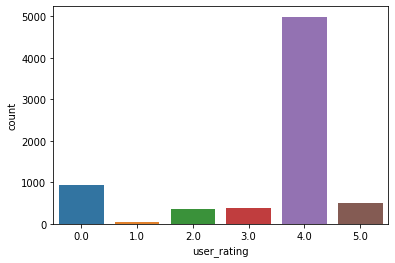

In [3]:
# Inspect the target
import seaborn as sns
sns.countplot(app.user_rating);

## 1.2 From logit to NN

When running a classification task, we are looking for a probability of a certain outcome. Here is the sigmoid function where *p* stands for target probability:
$$p=\frac{1}{1+e^{-y}}$$

The logistic regression formula would then be:

$$y=ln(\frac{p}{1-p})=\beta_{0}+\beta_{1}X_{1}+\beta_{2}X_{2}+...+\beta_{k}X_{k}+e$$

In matrix notation, this will look like:

$$\begin{bmatrix}  y_{1}\\  y_{2}\\   \vdots\\ y_{n}\\ \end{bmatrix}=\begin{bmatrix} 1 & x_{11}&\ldots\ & x_{1,k}\\  1 & x_2\\  \vdots & \vdots\\  1 & x_n&\ldots\ & x_{n,k}\\ \end{bmatrix}\begin{bmatrix}  \beta_{0}\\  \beta_{1}\\   \vdots\\ \beta_{k}\\ \end{bmatrix} +\begin{bmatrix}  e_{1}\\  e_{2}\\   \vdots\\ e_{n} \end{bmatrix}$$

Recall that logistic regression can be considered a one-layer neural network:

<img src="./LogtNN.png" alt="logit" style="width: 600px;"/>

Also note that $y$ in the above equation denotes the log-odds. Therefore, we actually depict a linear model, which we can equally state in matrix from as:

$$y=WX+b$$

where $W$ is the **weight** matrix, containing coefficients/betas for the covariates, and b is an error term or **bias**. To be precise, all of the above assumes $y$ to be the log-odds of a binary outcome variable. Things are a little more complicated when dealing with a multi-class problem. But let's not go there. Instead, depict our multi-class problem graphically as a NN.

<img src="nnn.png" alt="nn" style="width: 1200px;"/>

So have 35 variables and a target lable with 6 levels. How do we make it a NN task?

 ## 1.3 NN architecture ## 

We will start with so called "vanilla neural network", or ANN.
This is not deep learning yet, as we have just one "hidden layer".
 - a - input layer (number of neurons defined by number of features)
 - a' - hidden layer (number of neurons depends on the task, see best practice)
 - a'' - output layer (number of neurons depends on the type of output, 1 for regression, 2 for binary logistic regression, multiclass by number of classes)

<img src="nn_full.png" alt="fff" style="width: 800px;">


Additionally, every neuron of a hidden layer has an **activation function** that transforms the input. 
For example, if the activation function is $f(x)=x^2$ then with input $x=2$, the neuron will take the value of 4.

However, the usual "go to" functions for neural networks in recent years have been either *sigmoid*, *tanH*,  or *ReLu*.


## 1.4 activation function ##


In [4]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-5, 5, 100)

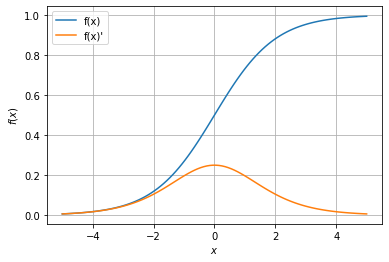

In [5]:
# Sigmoid function 
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1-s)

plt.plot(x, sigmoid(x), label='f(x)')
plt.plot(x, sigmoid_derivative(x), label="f(x)'")
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='best')
plt.show();

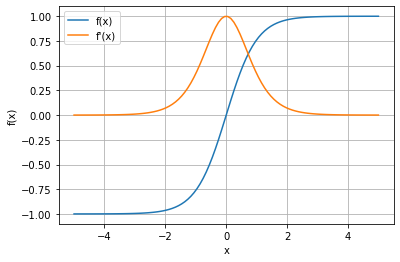

In [6]:
# Hyperbolic tangent
def tanH(x):
    return (np.exp(x)-np.exp(-x)) / (np.exp(x)+np.exp(-x))


def tanH_derivative(x):
    return 1-tanH(x)**2

plt.plot(x, tanH(x), label="f(x)")
plt.plot(x, tanH_derivative(x), label="f'(x)")
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

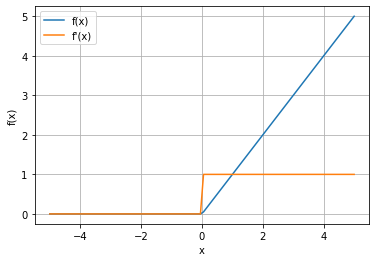

In [7]:
#RELU
def ReLU(x):
    return np.maximum(0, x)

def ReLU_derivative(x):
    return (ReLU(x)>0).astype(int)

    
plt.plot(x, ReLU(x), label="f(x)")
plt.plot(x, ReLU_derivative(x), label="f'(x)")
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

So we have here a fully connected layer. The connections between layers represent **2 weight matrices**:

<img src="nn_w.png" alt="ffcf" style="width: 800px;">

Here is the matrix notation:

<img src="m_notation.png" alt="mn" style="width: 800px;">    

And a single element computation:
$$a'_{0}= f(w_{0,0}a_{0}+w_{0,1}a_{1}+w_{0,2}a_{2}+w_{0,3}a_{3} +...+ b_{0})$$

$$
\begin{pmatrix} 
a'_{0}\\ a'_{1}\\ 
\vdots \\ 
a'_{h}\\
\end{pmatrix} =
f \Bigg(
\begin{pmatrix} 
w_{0,0} & w_{0,1} & \ldots & w_{0,k} \\ 
w_{1,0} & w_{1,1} &\ldots & w_{1,k}\\ 
w_{2,0} & w_{2,1} &\ldots & w_{2,k}\\ 
\vdots & \vdots & \ldots & \vdots\\
w_{h,0} & w_{h,1} & \ldots & w_{h,k}\\
\end{pmatrix}
\begin{pmatrix}
a_{0}\\ a_{1}\\ \vdots\\ a_{k}\\
\end{pmatrix}+
\begin{pmatrix}b_{0}\\  b_{1}\\
\vdots\\
b_{h}\\
\end{pmatrix}
\Bigg)
$$

The resulting output will not quite give us the desired result. 
The above computations will provide us with **scores**, while we are in need of probabilities, 
and not just probabilities, but the distribution of probabilities over the classes of
 our target variable. That's where **softmax** comes in. 

## 1.5 softmax function ##
Recall the softmax function:
$$S(x_{c})=\frac{e^{x_{c}}}{\sum_{j} e^{x_{j}}}$$

We give it a score $x_c$ representing the confidence of the model that instances $x$ belongs to class $c$. We then normalize the score across all classes. In Python, this looks as follows:

In [ ]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

Say we obtained some scores from our NN. Let's compute the softmax output for these scores.

In [ ]:
scores = [-100, -10, -0.5, -0.1, 0, 0.21]
probs = softmax(scores)
np.round(probs,4)  # round to make the output more readable

In [ ]:
# and of course, these outputs sum to one
sum(softmax(scores))

Here is a nice picture of the computation, which also hints as the next step. Once we have our model predictions, which will be estimated class probabilities thanks to softmax, we will compare these to the actual class labels and compute a loss. You will see the latter step later in the tutorial:
<img src="softmax.png" alt="ffff" style="width: 600px">

Source: [RitchiNg.com](https://www.ritchieng.com/machine-learning/deep-learning/neural-nets/)

## 1.6 Application
Let's try to set up the NN architecture on our own! We have already loaded our data.

In [ ]:
# Inspect the data
len(app) # that would be the number of observations

In [ ]:
# And here is one observation
app.iloc[5]

To prepare our data for the NN, we need to encode the labels. Currently, these are just numbers running from 0 to five.

In [ ]:
app["user_rating"].unique()

For our NN, we need the class labels as a matrix of dummies. In other words, we need to apply one-hot-coding to our labels. This facilitates calculating the loss of the NN using cross-entropy. The one-hot-coding is easily done using a keras utility function. 

In [ ]:
# convert integers to dummy variables (i.e. one hot encoded)
from keras.utils import np_utils
dummy_y = np_utils.to_categorical(app["user_rating"])
dummy_y  # 6 levels -> 6 columns

While that is enough we could make the case a little more comprehensive. Say your labels are not integers but classes, as in rating analysis for example where we have rating grades like AAA, AA, A, ..., D. Here is a standard workflow for dealing with labels in  multi-class problems. We first encode them to integers and then use one-hot-coding. Although it is an overkill for the focal case, it is good to see the typical process for once. 

In [ ]:
# Encode the target variable
from sklearn.preprocessing import LabelEncoder

# first encode the labels
encoder = LabelEncoder()
encoder.fit(app["user_rating"])
encoded_Y = encoder.transform(app["user_rating"])

# convert integers to dummy variables (i.e. one hot encoded)
from keras.utils import np_utils
dummy_y = np_utils.to_categorical(encoded_Y)
dummy_y  # 6 levels -> 6 columns

In [ ]:
# Some more housekeeping before we start with the NN
data = np.array(app)  # convert to numpy array
X = data[:,:-1]  # matrix of covariates only 
y = dummy_y.astype(int)  # type conversion of the target

# Done, here is the final target for the sixth app in the data frame. Remeber which one that was?
y[5]

In [ ]:
print(X.shape,y.shape)

### Let's set up the structure of our ANN

In [ ]:
# Determine the structure of the NN
inputLayer = 35  # by the number of features - a
hiddenLayer = 50 # hidden layer, as we decided - a'
outputLayer = 6  # output, by the number of levels - a''

Here is our NN structure again.

<img src="nn_ws.png" alt="ffcf" style="width: 800px;">

Apart from the input, hidden, and output dimension, we need to initialize the weight matrices. Completely random initialization will not work well. To do a little better than that, we use uniformly distributed random numbers in a bounded range. In a nutshell, this is to avoid neurons getting saturated. Glorot and Bengio (2010) and some deep learning tutorials set the boundary for random numbers based on the  number of incoming and outgoing connections:

$$ r = \sqrt{\frac{6}{\text{in} + out}} $$

where $in$ and $out$ represent the number of incoming and outgoing connections, respectively. You can then initialize weights to random numbers in the range $(-r,r)$. 

In [ ]:
# Facilitate replication by fixing the random number seed
np.random.seed(123)

limit = np.sqrt(6 / (inputLayer + outputLayer)) 

weightsInputToHidden  = np.random.uniform(-limit, limit, (hiddenLayer, inputLayer)) # W in the picture
weightsHiddenToOutput = np.random.uniform(-limit, limit, (outputLayer, hiddenLayer)) # M in the picture

biasInputToHidden  = np.ones( (hiddenLayer,1) ) # for sigmoid to pick 0, for ReLu you pick one - b
biasHiddenToOutput = np.ones( (outputLayer,1) ) #  v


We will be inputing just one observation for now. 

In [ ]:
#X[5]
app.iloc[5,:]

In [ ]:
# We need to ensure that the input comes as an array of correct dimension
print(X[5].shape)

In [ ]:
# This will not work since, for matrix multiplication, we need a kx1 vector
inputs = np.array(X[5]).reshape( (35,1) )
inputs.shape # now we have a nice and sweet input vector!

In [ ]:
# Now we need to make sure our output vectors will be what we want it to be. 
# That is basically the same operation as above
print(y[5].shape)
target = y[5].reshape( (6,1) )
target.shape

In [ ]:
# Show matrices of weights
weightsInputToHidden.shape, inputs.shape, weightsHiddenToOutput.shape, target.shape

Ok, we are all set, let's multiply!

In [ ]:
hL_inputs = np.dot(weightsInputToHidden, inputs) + biasInputToHidden
hL_outputs = ReLU(hL_inputs)
hL_outputs.shape

In [ ]:
oL_inputs = np.dot(weightsHiddenToOutput, hL_outputs) + biasHiddenToOutput
oL_inputs
#doesn't look like probabilities, that's because these are our scores

In [ ]:
oL_outputs = softmax(oL_inputs)
oL_outputs

In [ ]:
# and just for verification
np.sum(oL_outputs)

In [ ]:
## So what was the label again?
target

Our model is somewhat on the way but still a little uncertain, we need to give it a nudge in the right direction. So how do you usually tell the model it's wrong? You show it the evaluation metric and try to make it better.

To evaluate the the probabilities estimated by the model, we need to compare them with the true values, 
that are one-hot encoded in our case. So we need to compare our outputs to 

[ 0, 0, 0, 0, 1, 0]

You can imagine that we cannot use MSE here, as we are dealing with a certain probability distribution.
Our *loss function* has to grasp the difference between these probabilities. This is where the **cross-entropy loss**
function will come in handy. It is used when the output of a model represents the probability of an outcome, i.e. when the output is a probability distribution. 
It is used as a loss function in neural networks that have softmax activations in the output layer.

*Remark*: in case you are interested, there a nice article (with codes) on the differences between squared-error and cross-entropy
in the context of training neural networks appeared in the [Visual Study magazine](https://visualstudiomagazine.com/articles/2017/07/01/cross-entropy.aspx).

# Phase 2: make it work # 
 1. loss function
 2. gradient
 4. batches
 5. learning rate
 6. stochastic gradient descent
 7. backpropagation

## 2.1 Loss function
### Logistic regression case
Let us revisit classic logistic regression. We build a linear model to distinguish between two classes. So our target variable can only take one of two states $ y \in \{0,1\} $.

With $ w$ denoting the parameters (aka weights) of our logit model and letting observations be indexed by $i = 1, 2, ..., n$, our loss function $J(w)$ has the form:

$$J(w) = \sum_{i=1}^{n} y^{(i)} \log P(y=1) + (1 - y^{(i)}) \log P(y=0)$$
Where P(y) represent the probability of a certain binary outcome

We will however consider another loss function - cross entropy. It is used when the output represents the probability of an outcome, i.e. when the output is a probability distribution. It is used as a loss function in neural networks that have softmax activations in the output layer.

### Cross-entropy 
Entropy ($H(y)$) is a term from Information Theory. It had a great impact on the field of communication and signifies the optimal number of bits to encode a certain information content ($y_c$ is the probability of the c-th event, symbol or in our case class):

$$H(y) = \sum_c y_c \log \frac{1}{y_c} = -\sum_c y_c \log y_c$$

Now the cross-entropy ($H(y,\hat{y})$) is the number of bits we'll need if we encode symbols from $y$ using the wrong tool $\hat{y}$. Cross entropy is always bigger or equal to entropy. Mind that $c$ stands for the number of classes. 

$$H(y, \hat{y}) = \sum_c y_c \log \frac{1}{\hat{y}_c} = -\sum_c y_c \log \hat{y}_c$$

Interestingly enough, the The KL divergence that you have encountered before in BADS (uplift random forest) is simply the difference between cross entropy and entropy:
$$\mbox{KL}(y~||~\hat{y})
= \sum_c y_c \log \frac{1}{\hat{y}_c} - \sum_c y_c \log \frac{1}{y_c}
= \sum_c y_c \log \frac{y_c}{\hat{y}_c}$$

We would be calculating the cross-entropy for every pair of true/estimated probabilities and averaging it over the sample or batch (more about it later) - this will be our loss function *L* that we will ultimately want to minimise (class i, smaple j):

$$L=-\frac{1}{N}\sum_i \sum_c y_{i,c} \log(\hat{y}_{i,c})$$

#### CE example
A concrete example is the best way to explain the purely mathematical form of CE. Suppose you have a weirdly shaped
four-sided dice (yes, I know the singular is really "die"). Using some sort of intuition or physics, you predict
that the probabilities of the four sides are (0.20, 0.40, 0.30, 0.10). 
You then roll the dice many thousands of times and determine that the true probabilities are  (0.15, 0.35, 0.25, 0.25). 
Here is how we calculate the CE error of our prediction:

CE prediction error:
-1.0 * [ ln(0.20) * 0.15 + ln(0.40) * 0.35 + ln(0.30) * 0.25 + ln(0.10) * 0.25 ] = 
-1.0 * [ (-1.61)(0.15) + (-0.92)(0.35) + (-1.20)(0.25) + (-2.30)(0.25) ] =
1.44

In [ ]:
import numpy as np
ce=-1.0 * (np.log(0.20) * 0.15 + np.log(0.40) * 0.35 + np.log(0.30) * 0.25 + np.log(0.10) * 0.25)
print('Cross entropy error of weird dice prediction is: {:.4f}'.format(ce))

Let us apply this idea to our network outputs.

In [ ]:
yhat=np.round(oL_outputs, 3) #that's our WX+b run through softmax
print('True label: ',  target.shape)
print(target)
print('Prediction: ', yhat.shape)
print(yhat)

In [ ]:
# Calculation of cross-entropy loss
L =- sum(target*np.log(yhat))
print(L.item())

In [ ]:
# or, if you prefer
L=-1*np.dot(target.T, np.log(yhat))
print(L.item())

This is the number we want the machine to minimize! But how?
We ca not change our input, we cannot change our labels, what we can adjust are **weights and biases** - these are the parameters of our neural network. So we need to change our **W, M, b and v** and check if the loss decreases.

NB: number of neurons in the hidden layer AND number of hidden layers are meta-parameters and certainly can be experimented with, we will discuss it further down the course.

The most efficient way to move around the function slope is to find the derivative.

In our naive example, we are dealing with 1 example only while we have 6 classes. In practice, these numbers, the number of examples and output classes would be much larger, making the calculation of the derivative of the loss function computationally demanding. 

And that was the point when everybody almost gave up on neural networks. Spoiler alert: the solutions were **stochastic gradient descent and backpropagation**.


## 2.2 Gradient 
The gradient ( $\nabla$) is a vector operation which operates on a scalar function to produce a vector whose magnitude is the maximum rate of change of the function at the point of the gradient and which is pointed in the direction of that maximum rate of change. 

Well, put in easier terms, gradient is a **vector of partial derivatives**. Why would we need it? Because we need the derivative of this:
$$L=-\frac{1}{N}\sum\sum y\log(softmax(M(relu(Wx+b))+v)),$$

where the functions $s$ and $r$ stand for softmax, and relu, respectively.


We want to adjust every estimation of y (yhat) so as to minimize the loss function. For that we would deduct a gradient of the loss function from it and continue doing these iterations until we reach the local minimum. 
$$L_{t+1} =L_t - \eta \cdot \nabla L(W, M, b, v)$$

You can think of of gradient as a list of directions for improvement (of course, imagining moving in 10000 directions is hard):
$$ \nabla L(W,M,b,v)=\begin{bmatrix}  \frac{dL}{dW}\\ \frac{dL}{dM}\\ \frac{dL}{db}\\ \frac{dL}{dv}\end{bmatrix}$$

Normally it would be a result of averaging over all observations that went through the forward pass, but again- we have just one this time.

In [ ]:
%%html
<iframe src="https://giphy.com/embed/8tvzvXhB3wcmI" width="1000" height="400" frameBorder="0" class="giphy-embed" allowFullScreen></iframe>
<p><a href="https://giphy.com/gifs/deep-learning-8tvzvXhB3wcmI">via GIPHY</a></p>

### Gradient descent example
For illustration purpose, we will try to find the local minimum of the function $ f(x) = \left(x-4\right)^2 $. In this case, the gradient is a simple derivative: $2 \left(x-4\right)$.

The example draws on: https://towardsdatascience.com/implement-gradient-descent-in-python-9b93ed7108d1

In [ ]:
cur_x = 10 # Randomly guessed starting point 
rate = 0.1 # Learning rate

# Let's impose two stopping conditions, a max. number
# of iterations and a minimum step size
precision = 0.000001 # threshold for the step size
previous_step_size = 1 # change of x in the prev. step
max_iters = 10 # maximum number of iterations
iters = 0 #iteration counter

df = lambda x: 2*(x-4) #Gradient of our function '

while previous_step_size > precision and iters < max_iters:
    prev_x = cur_x #store current x value in prev_x
    cur_x = cur_x - rate * df(prev_x) # gradient descent step
    previous_step_size = abs(cur_x - prev_x) # change in x
    iters = iters+1 #iteration count
    if (iters%5 == 0.0):
        print("Iteration {:02d} with X equal to {:.4f}".format(iters,cur_x)) #Print iterations
    
print("The local minimum occurs at: {:.10f}".format(cur_x))

## 2.3 updating weights
The following codes sketch gradient descent for neural network learning. For simplicity, we consider the squared-error loss function. Its derivative is very easy and more handy compared to cross-entropy. 

Furthermore, since we minimize squared-error, we do not need the softmax layer anymore. Instead, we could   minimize the error for the raw output scores of the NN. The softmax derivative is a little complicated. Thus, avoiding softmax simplifies our example. Rather, we don't avoid it entirely but replace the softmax function with ReLU. ReLU ensures that our network outputs are strictly positive. We could still interpret these outputs as unnormalized confidences for the different classes. That is perfectly fine for this example. After all, the concepts illustrated below also apply to the cross-entropy loss function or yet other loss functions and networks with softmax layer.

Let's try to write down our simplified modeling problem:

$$L=-\frac{1}{N}\sum\sum \frac{1}{2}(y - relu(M(relu(Wx+b))+v)^2 ),$$

To minimize this loss function, we need its derivative, which is equal to the model residuals, and the derivative of our ReLU activation function.

In [ ]:
def loss_derivative(output, y): #check the derivation if interested https://sefiks.com/2017/12/17/a-gentle-introduction-to-cross-entropy-loss-function/
    return output - y

def ReLU_derivative(x):
    return (x>0)*1.0

In the third lecture, we went through the steps in backpropagation. You might want to revisit the steps and have the slides ready when going through the following steps.

In [ ]:
# First, we reproduce the steps in the calculation of the forward path from above
inputs = np.array(X[5]).reshape( (35,1) )  # one example from the data set
target = y[5].reshape( (6,1) )  # one-hot-coded app rating
hL_inputs = np.dot(weightsInputToHidden, inputs) + biasInputToHidden  # input to hidden layer
hL_outputs = ReLU(hL_inputs)  # hidden layer output
oL_inputs = np.dot(weightsHiddenToOutput, hL_outputs) + biasHiddenToOutput  # input to output layer
oL_outputs = ReLU(oL_inputs)  # above we used softmax, as said, we simplify the example and use ReLU
oL_outputs

Next we do the backward pass and work out gradients. We begin with the weight matrix M, that connects the hidden to the output layer.

In [ ]:
# 1. We first need the residuals, which are equal to the derivative of our loss
dL_dyhat = loss_derivative(oL_outputs, target)
dL_dyhat

In [ ]:
# 2. Next we need the derivative of the predictions wrt the output layer activation; normally softmax and here ReLU for simplicity
dyhat_dact = ReLU_derivative(oL_inputs)
dyhat_dact

In [ ]:
# 3. The last factor in the chain is the derivative of the output layer input wrt the hidden layer output
# This is simply the output of the hidden layer, so no computations needed.
hL_outputs.shape

In [ ]:
# Before moving on, let's revisit the dimensionality of our factors
dL_dyhat.shape, dyhat_dact.shape, hL_outputs.shape, 

In [ ]:
# We are set up to calculate the first gradient
gradient_HiddenToOutput = np.dot(dL_dyhat * dyhat_dact, np.transpose(hL_outputs))
gradient_HiddenToOutput.shape

In [ ]:
# Just what we need for our gradient update
weightsHiddenToOutput.shape

In [ ]:
# The hidden layer also as biases and we need to update these, too. Following the same logit as above,
# we arrive at,
gradient_HiddenToOutput_bias = dL_dyhat * dyhat_dact
# To see this, go back to the above equation and note that our bias, v, enters the loss function. We do not
# need to consider the output of the hidden layer in our gradient computation. Everything else remains the same.

We already found two parts of our gradient. Let's proceed with the weight matrix W, connecting the hidden and the input layer. We need to go through similar steps as before. More specifically, we begin exactly as before and find the derivative of the loss wrt the NN prediction and the derivative of the prediction wrt our ReLU output layer activation. Remember that caching intermediate results is crucial in the scope of  backpropagation.     

In [ ]:
# We have already performed this computation twice and now we need it again. Let's finally store the result
# Yes, we could and should have done this earlier; but doing things wrong for once helps to learn ;)
# We can give our cached results any name we like but the term output layer error is commonly used
oL_errors = dL_dyhat * dyhat_dact  
print('Shape output layer error {}'.format(oL_errors.shape))
# When backpropagating errors further down our network, the next factor we need is the derivative of the 
# output layer input wrt the hidden layer output. This is the weight matrix M, because of the linear 
# relationship between these two quantities. 
print('Shape of M {}'.format(weightsHiddenToOutput.shape))
gradient_InputToHidden = np.dot(weightsHiddenToOutput.T, oL_errors)

# Thereafter, we add another factor, which is the derivative of the hidden layer output wrt the
# hidden layer input. So we need our ReLU derivative again
gradient_InputToHidden = gradient_InputToHidden * ReLU_derivative(hL_inputs)
print('Shape of gradient vector {}'.format(gradient_InputToHidden.shape))

# Finally, the hidden layer inputs depend on the weights in a linear manner. The derivate of the hidden
# layer input wrt to the weight matrix W, which gradient we seek, is equal to the inputs x
print('Shape of input {}'.format(inputs.shape))
gradient_InputToHidden = np.dot(gradient_InputToHidden, np.transpose(inputs)   )
gradient_InputToHidden.shape

In [ ]:
# Calculating the gradient of the loss wrt the hidden layer bias is again a little easier.
# We go through the same steps as above but the last step. The inputs to not enter the calculation
gradient_InputToHidden_bias = np.dot(weightsHiddenToOutput.T, oL_errors) * ReLU_derivative(hL_inputs)

Noting that every step in the calculation of $\frac{dL}{db}$ repeats a large part of the calculation of $\frac{dL}{dW}$ informs us that we have once again missed an opportunity to write efficient code.

Finally, we have collected all gradients and can update the weights using the standard gradient descent rule. 

In [ ]:
# Gradient descent step
learningRate = 0.0001  # define some learning rate

# Update M
weightsHiddenToOutput -= learningRate * gradient_HiddenToOutput
# Update v
biasHiddenToOutput -= learningRate * gradient_HiddenToOutput_bias 
# Update W
weightsInputToHidden -= learningRate * gradient_InputToHidden
# Update b
biasInputToHidden -= learningRate * gradient_InputToHidden_bias

## 2.4 Stochastic gradient descent and backpropagation

Apart from derivatives, avereging over the whole training dataset might be costly. That is why **stochastic** gradient descent was introduced. It basically means that instead of using the full training set, the algorithm will only use a certain  random **batch** (size of this batch is a metaparameter like the number of neurons). This introduces a certain "slopinness" to the process but allows to run the **backpropagation** much faster. After many iterations, we expect to converge to the sample parameters anyway. Below, we exemplify backpropagation for our simple neural network. To that end, we require another important concept, an **epoch**. An epoch describes on run of the entire data set through the NN. 

Essentially, Backpropagation is an algorithm for computing the gradient in a multidimensional space. You can find a very good description of the algorithm in the [ML Glossary](https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html). Here is a picture illustrating the idea.


<img src="nn_color.png" alt="Backpropagation" style="width: 800px;"/>

## 2.5 Updating for each observation in the data (the original stochastic gradient descent)

In [ ]:
learningRate = 0.0001
epochs = 10 # how many times do we have to run the training set through the network

input_dim = X.shape[1] # number of variables
n_classes = y.shape[1]  # number of classes (i.e., 6 user ratings one-hot encoded)

In [ ]:
iteration=0

while iteration < epochs:
    
    # Put all the steps done before in a loop:
    # Process one observation per iteration 
    squared_residuals = np.zeros(X.shape[0]) # to keep track of the loss
    for i in range(X.shape[0]):

        inputs  = np.array(X[i]).reshape( (input_dim,1) ) # select current case i
        target = y[i].reshape( (n_classes,1) ) # and its target value
                
        # Compute the forward pass through the network all the way up to the final output  
        hL_inputs = np.dot(weightsInputToHidden, inputs) + biasInputToHidden
        hL_outputs = ReLU(hL_inputs)
        oL_inputs = np.dot(weightsHiddenToOutput, hL_outputs) + biasHiddenToOutput 
        oL_outputs = ReLU(oL_inputs) # final output: probabilistic prediction for case i 

        # Compute the gradients:
        # gradient for the weights between hidden and output layers
        gradient_HiddenToOutput = loss_derivative(oL_outputs, target) * ReLU_derivative(oL_outputs)
        oL_errors = gradient_HiddenToOutput
        
        # gradient for the weights between input and hidden layers
        gradient_InputToHidden = np.dot(weightsHiddenToOutput.T, oL_errors) * ReLU_derivative(hL_inputs)

        # Perform gradient descent update
        biasHiddenToOutput -= learningRate * gradient_HiddenToOutput
        biasInputToHidden  -= learningRate * gradient_InputToHidden

        weightsHiddenToOutput -= learningRate * np.dot(gradient_HiddenToOutput, np.transpose(hL_inputs))
        weightsInputToHidden  -= learningRate * np.dot(gradient_InputToHidden, np.transpose(inputs))
        
        # Store residual 
        squared_residuals[i] = np.sum((target-oL_outputs)**2)
        
    # Development of the loss as average over obs-level losses
    print('Epoch {} with loss {:.4f}'.format(iteration, np.mean(squared_residuals)))
    iteration += 1


That is the end of our simplified manual backprob demo. After going through the code you should extend your skills by browsing through some more elaborate tutorials such as https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795 or https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/.

### Let's check the results! ##

In [ ]:
# Extract some 'test' data
X_test = data[78:178,:-1]
y_test = dummy_y[78:178].astype(int)
y_test = np.argmax(dummy_y[78:178], axis=1)

In [ ]:
# scorecard of the network
confusion_matrix = np.zeros( (6,6), dtype="int" )
true_labels = np.argmax(y, axis=1)
pred_labels = np.zeros_like(true_labels)
# go through all the observations in the test data set
for i in range(len(y)):
    # compute the network output (using the trained weights)
    inputs = np.array(X[i]).reshape( (35,1) )

    hL_inputs = np.dot(weightsInputToHidden, inputs) + biasInputToHidden
    hL_outputs = ReLU(hL_inputs)
    oL_inputs = np.dot(weightsHiddenToOutput, hL_outputs) + biasHiddenToOutput
    oL_outputs = softmax(oL_inputs)  # that is a bit of cheating since we trained using ReLU

    # determine most likely class
    pred_labels[i] = np.argmax(oL_outputs)

    confusion_matrix[pred_labels[i], true_labels[i]] += 1

In [ ]:
confusion_matrix

In [ ]:
# Calculate percentage correctly classified
pcc = np.trace(confusion_matrix) / len(y)
print('Classification accuracy of trained network: {:.2f}'.format(pcc))

Ok, not too bad for our first neural network and a lot better than random guessing ...

In [ ]:
guessed_class = np.random.randint(0,6, y.shape[0])
m=pd.crosstab(guessed_class, true_labels)
m

In [ ]:
print('Classification accuracy of randomly guessing classes: {:.2f}.'.format(np.trace(m.to_numpy()) / len(y)))

## 2.6 Learning rate
Learning rate is a **hyper-parameter** that controls how much we are adjusting the weights of our network with respect the loss gradient. 
Lower LR takes more time but allows better allocation of local minimum, higher LR allows faster calculations but drastic jumps do not always yield good results. 
        $$ newWeights=OldWeights - learningRate *gradientOfOldWeights$$ 

<img src="http://cs231n.github.io/assets/nn3/learningrates.jpeg" alt="Drcng" style="width: 400px;"/>Img Credit: cs231n

One can improve the results of computations significantly if learning rate is set well. However, learning rate might not remain the same throughout the training. The concpet of cyclical learning rate was introduced by Leslie N.Smith in 2015, it conveys a certain schedule when the LR starts with small values and increases (either linearly or exponentially) at each iteration. Learning rate decay would provide an alternative, it would bare the same problem though - when to decay the LR (step decay, exponential decay, others). In practice, step decay is preferred by many practitioners as hyperparameters it involves (the fraction of decay and the step timings in units of epochs) are more interpretable. 

learning_rate = 0.1
decay_rate = learning_rate / epochs

## 2.7 Momentum

$$\Delta  W_{i} = -learningRate  \frac{\partial L}{\partial W} + \mu  \Delta W_{i-1}$$


The second part that contains $\mu$ is a momentum term here (or coefficient), that defines the effect of the accumulated past gradient (we are taking an exponentially weighted moving average of accumulated updates). You can think of it as a certain velocity control mechanism. When we reach flatter areas, it will increase the speed of convergence, while dampening oscillations when reaching high curvatures. If the learning rate measures how much the current situation affects the next step, momentum measures how much past steps affect the next step. 

Conventional values to set for momentum is 0.5 increasing to 0.9, in case of cross validation can be set to values such as [0.5, 0.9, 0.95, 0.99]

**Nesterov Momentum** is a slightly different version of the momentum update that has recently been gaining popularity. It is set as a meta-parameter in basic Keras application that we will see in the next tutorial. In simplified terms, Nesterov momentum gives gradient a better 'nudge' as it contains a 'lookahead' information. 

# Further study

I strongly recommend watching this video from 3blue1brown on neural network training using gradient descent and backpropagation: https://www.youtube.com/watch?v=tIeHLnjs5U8&list=PLLMP7TazTxHrgVk7w1EKpLBIDoC50QrPS&index=4

In my opinion, this is the single most intuitive explanation available on the internet.